<a href="https://colab.research.google.com/github/skywalker0803r/mxnet_course/blob/master/mxnet_REINFORCE_Hybrid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#!pip install mxnet
import sys
import mxnet  
import gym
import numpy as np  
from mxnet import nd,autograd,init
from mxnet.gluon import nn,trainer
import matplotlib.pyplot as plt
from mxnet.gluon import Trainer

# PolicyNetwork

In [0]:
def build_policy(net,num_actions):
  with net.name_scope():
    net.add(nn.Dense(128,activation='relu'))
    net.add(nn.Dense(num_actions))
  return net

In [70]:
#test
p = build_policy(nn.HybridSequential(),2)
p.initialize(init=init.Xavier())

s1 = np.array([1,2,3,4])
s2 = np.array([2,3,4,5])
batch_state = np.stack([s1,s2])

s1 = nd.array([s1])
s2 = nd.array([s2])
batch_state = nd.array(batch_state)

print('===============')
print(p(s1))
print('===============')
print(p(batch_state))


[[ 0.10889705 -0.8330167 ]]
<NDArray 1x2 @cpu(0)>

[[ 0.10889705 -0.8330167 ]
 [ 0.26567897 -1.0653929 ]]
<NDArray 2x2 @cpu(0)>


# main loop

In [0]:
#!sudo pip install box2d-py

0 12.0
20 21.0
40 52.0
60 18.0
80 9.0
100 13.0
120 42.0
140 39.0
160 17.0
180 72.0
200 44.0
220 47.0
240 200.0
260 166.0
280 200.0
300 125.0
320 200.0
340 182.0
360 200.0
380 172.0
400 200.0
420 200.0
440 83.0
460 137.0
480 126.0
500 194.0
520 200.0
540 147.0
560 200.0
580 100.0
600 200.0
620 166.0
640 158.0
660 186.0
680 195.0
700 180.0
720 174.0
740 200.0
760 200.0
780 200.0
800 200.0
820 200.0
840 200.0
860 198.0
880 172.0
900 51.0
920 200.0
940 176.0
960 200.0
980 142.0


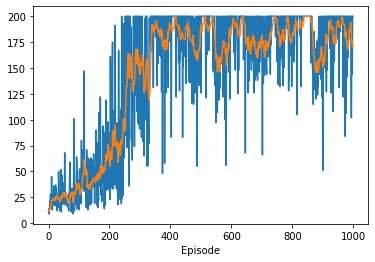

In [72]:
env = gym.make('CartPole-v0')

policy_net = build_policy(nn.HybridSequential(),env.action_space.n)
policy_net.initialize(init=init.Xavier())
policy_net.hybridize()

trainer = Trainer(policy_net.collect_params(),'adam',{'learning_rate':0.001})

max_episode_num = 1000
max_steps = 10000

numsteps = []
avg_numsteps = []

all_rewards = []
avg_all_rewards = []

for episode in range(max_episode_num):
  state = env.reset()
  log_probs = []
  rewards = []
  with autograd.record():
    for t in range(max_steps):
      state = nd.array(np.expand_dims(state, 0))
      probs = nd.softmax(policy_net(state))
      action,log_prob = nd.random.multinomial(probs,get_prob=True)
      state, reward, done, _ = env.step(action.asnumpy()[0])
      log_probs.append(log_prob)
      rewards.append(reward)
      if done:
        break
    
    # logging
    numsteps.append(t)
    avg_numsteps.append(np.mean(numsteps[-10:]))
    
    all_rewards.append(np.sum(rewards))
    avg_all_rewards.append(np.mean(all_rewards[-10:]))

    # reverse accumulate and normalize rewards
    R = 0
    for i in range(len(rewards)-1, -1, -1):
      R = rewards[i] + 0.9 * R
      rewards[i] = R
    rewards = np.array(rewards)
    rewards -= rewards.mean()
    rewards /= rewards.std() + np.finfo(rewards.dtype).eps
      
    # compute loss
    loss = []
    for log_prob,Gt in zip(log_probs,rewards):
      loss.append(log_prob*(-Gt))
    
    # loss backward
    autograd.backward(loss)
  
  # gradient descent
  trainer.step(t)
  
  # print info
  if episode % 20 == 0:
    print(episode,all_rewards[-1])

plt.plot(all_rewards)
plt.plot(avg_all_rewards)
plt.xlabel('Episode')
plt.show()

In [0]:
policy_net.export('my_model',epoch=800)

In [74]:
deserialized_net = nn.SymbolBlock.imports("my_model-symbol.json", 
                                          ['data'], 
                                          "my_model-0800.params")

/usr/local/lib/python3.6/dist-packages/mxnet/gluon/block.py:1159: UserWarning: Cannot decide type for the following arguments. Consider providing them as input:
	data: None
  input_sym_arg_type = in_param.infer_type()[0]


In [79]:

env = gym.make('CartPole-v0')
policy_net = deserialized_net

for episode in range(10):
  state = env.reset()
  rewards = []
  for t in range(max_steps):
    state = nd.array(np.expand_dims(state, 0))
    probs = nd.softmax(policy_net(state))
    action,log_prob = nd.random.multinomial(probs,get_prob=True)
    state, reward, done, _ = env.step(action.asnumpy()[0])
    rewards.append(reward)
    if done:
      break
  
  # print info
  print(episode,np.sum(rewards))

0 152.0
1 200.0
2 140.0
3 172.0
4 200.0
5 123.0
6 174.0
7 200.0
8 133.0
9 200.0
